In [6]:
import scanpy as sc
import pandas as pd
import anndata as ad
import harmonypy as hm
import numpy as np
import matplotlib.pyplot as plt
import pertpy as pt
from scipy import sparse

import warnings
warnings.filterwarnings('ignore')

## 1. Load in data and integrate clinical metadata

In [7]:
metadata = pd.read_csv("GSE267814_series_matrix.txt", skiprows=30, sep="\t")
metadata = metadata.set_index(metadata.columns[0]).T
metadata.index.name = '!Sample_title'

# Making all columns unique
metadata.columns = pd.Series(metadata.columns).astype(str)
metadata.columns = metadata.columns.where(~metadata.columns.duplicated(), 
                                           metadata.columns + "_" + metadata.columns.duplicated().cumsum().astype(str))

In [ ]:
data_dir = "GSE267814_RAW"

adata_list = []

for sample_id, row in metadata.iterrows():
    accession = row['!Sample_geo_accession']
    base_path = "GSE267814_RAW"
    sample = accession + "_" + sample_id

    print("Reading in " + sample)

    matrix = f"{base_path}/{sample}_matrix.mtx"
    features = f"{base_path}/{sample}_features.tsv"
    barcodes = f"{base_path}/{sample}_barcodes.tsv"

    adata = sc.read_mtx(matrix).T
    adata.var['gene_ids'] = pd.read_csv(features, header=None, sep="\t")[0].values
    adata.var['gene_symbols'] = pd.read_csv(features, header=None, sep="\t")[1].values

    adata.var_names = adata.var['gene_symbols']
    adata.var_names_make_unique()

    # adata.obs['barcodes'] = pd.read_csv(barcodes, header=None)[0].values
    # adata.obs_names = adata.obs['barcodes']
    adata.obs_names = pd.read_csv(barcodes, header=None)[0].values

    adata.obs['sample'] = sample

    # Access and add metadata details
    adata.obs['tissue'] = row['!Sample_characteristics_ch1'].split(":")[1].strip()
    adata.obs['treatment'] = row['!Sample_characteristics_ch1_1'].split(":")[1].strip()
    adata.obs['procedure'] = row['!Sample_characteristics_ch1_2'].split(":")[1].strip()
    adata.obs['response'] = row['!Sample_characteristics_ch1_3'].split(":")[1].strip()

    assert adata.obs_names.is_unique, f"obs_names not unique in sample {sample}"
    assert adata.var_names.is_unique, f"var_names not unique in sample {sample}"


    adata_list.append(adata)


adata = ad.concat(adata_list, join='outer')
adata

Reading in GSM8279204_01-01B
Reading in GSM8279205_01-01T
Reading in GSM8279206_01-04B
Reading in GSM8279207_01-05B
Reading in GSM8279208_01-06T
Reading in GSM8279209_02-01B
Reading in GSM8279210_02-01TL
Reading in GSM8279211_02-01TP
Reading in GSM8279212_02-02B
Reading in GSM8279213_02-02T
Reading in GSM8279214_02-06B
Reading in GSM8279215_02-07B
Reading in GSM8279216_02-07T


AnnData object with n_obs × n_vars = 110795 × 36601
    obs: 'sample', 'tissue', 'treatment', 'procedure', 'response'

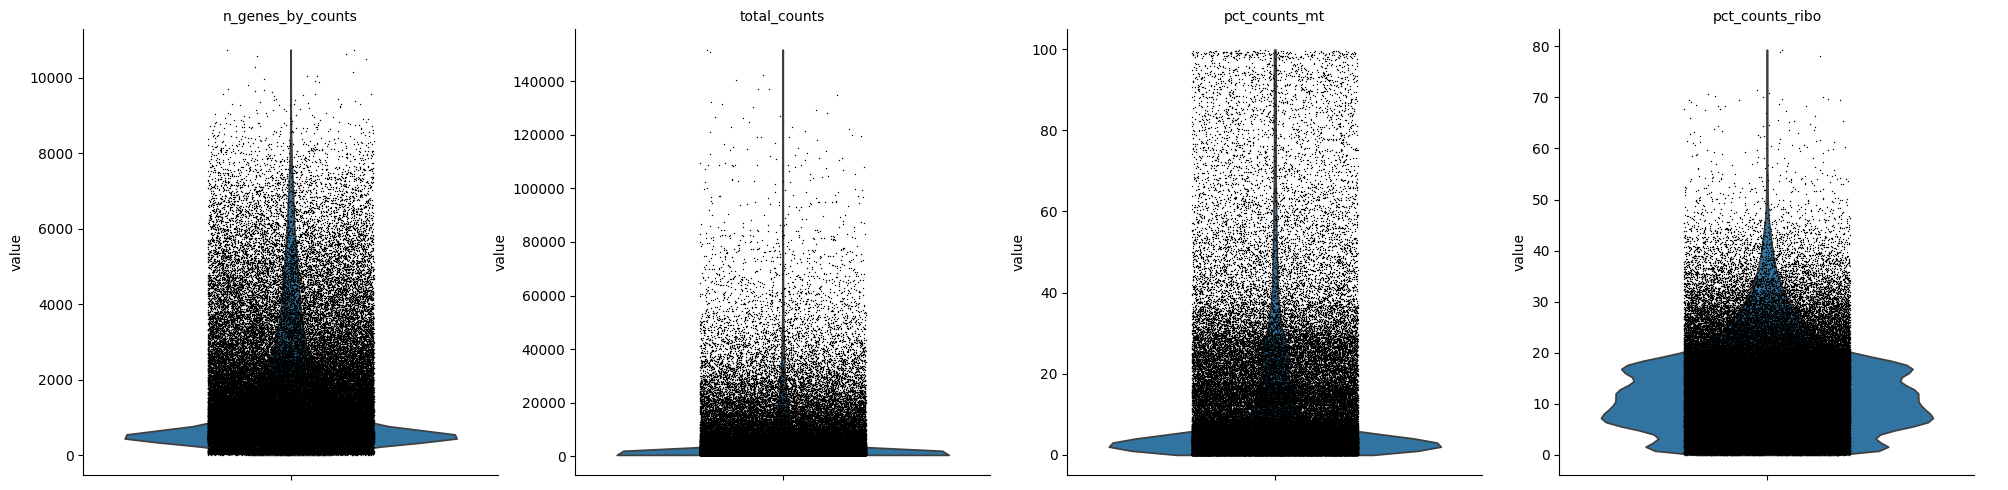

Total number of cells: 110795
Number of cells after mt filter: 93054
Number of cells after gene filter: 85259
After mt genes removal:  36588
After ribo genes removal:  36485


In [10]:
# 1. Finding mitochondrial and ribosomal genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# 2. Computing QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

# 3. Violin plot of QC metrics
sc.pl.violin(
    adata,
    keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.2,
    multi_panel=True
)

# 4. Filtering data based on QC thresholds
print("Total number of cells: {:d}".format(adata.n_obs))
## 1. Threshold of MT percent to 20%
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))
## 2. Remove cells with less than 300 genes
sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))
## 3. Remove ribosomal and mitochondrial genes
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

In [ ]:
# Keep raw
adata.layers["raw"] = adata.X.copy()

# Convert to dense matrix if needed
raw_counts = adata.X
if sparse.issparse(raw_counts):
    raw_counts = raw_counts.toarray()

# DataFrame of raw counts
counts_df = pd.DataFrame(raw_counts, index=adata.obs_names, columns=adata.var_names)
counts_df['sample'] = adata.obs['sample'].values

# Sum counts per gene per sample (pseudobulk)
pseudobulk_counts = counts_df.groupby('sample').sum().T  # Genes x Samples
pseudobulk_counts.to_csv("pseudobulk_counts.csv")

# Prepare metadata
sample_metadata = adata.obs[['sample', 'response', 'treatment']].drop_duplicates().set_index('sample')
sample_metadata.to_csv("pseudobulk_metadata.csv")